# Credit Card Fraud Detection Analysis

This notebook implements credit card fraud detection using anomaly detection techniques.

## Overview
- We'll use two unsupervised learning algorithms: Isolation Forest and Local Outlier Factor (LOF)
- These techniques are effective for detecting outliers/anomalies in the data
- Credit card fraud detection is a classic application of anomaly detection

In [45]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve, make_scorer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Import your existing utility module
import credit_card_fraud_utils as ccf





%matplotlib inline
plt.style.use('seaborn-v0_8') # Updated style name for compatibility

## 1. Setup and Configuration

In [46]:
# Initialize configuration
config = ccf.Config()

# You can modify config parameters here if needed
# config.IF_CONTAMINATION = 0.02
# config.LOF_N_NEIGHBORS = 25

# Display default configuration
print("Configuration Parameters:")
for attr, value in config.__dict__.items():
    print(f"{attr} = {value}")

Configuration Parameters:


## 2. Data Loading and Understanding

In [47]:
# Load the dataset
df = ccf.load_data(config)

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"Number of Transactions: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

# Display the first few rows
df.head()

Dataset Shape: (284807, 31)
Number of Transactions: 284807
Number of Features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [48]:
# Get a summary of the dataset
summary = ccf.get_data_summary(df)

print(f"Missing Values: {summary['missing_values']}")
print(f"Normal Transactions: {summary['normal_count']} ({100 - summary['fraud_percentage']:.2f}%)")
print(f"Fraudulent Transactions: {summary['fraud_count']} ({summary['fraud_percentage']:.2f}%)")

# Based on the actual fraud percentage, we might want to update the contamination parameter
print(f"\nRecommended contamination value: {summary['fraud_percentage'] / 100:.6f}")
config.IF_CONTAMINATION = summary['fraud_percentage'] / 100
config.LOF_CONTAMINATION = summary['fraud_percentage'] / 100

Missing Values: 0
Normal Transactions: 284315 (99.83%)
Fraudulent Transactions: 492 (0.17%)

Recommended contamination value: 0.001727


## 3. Exploratory Data Analysis

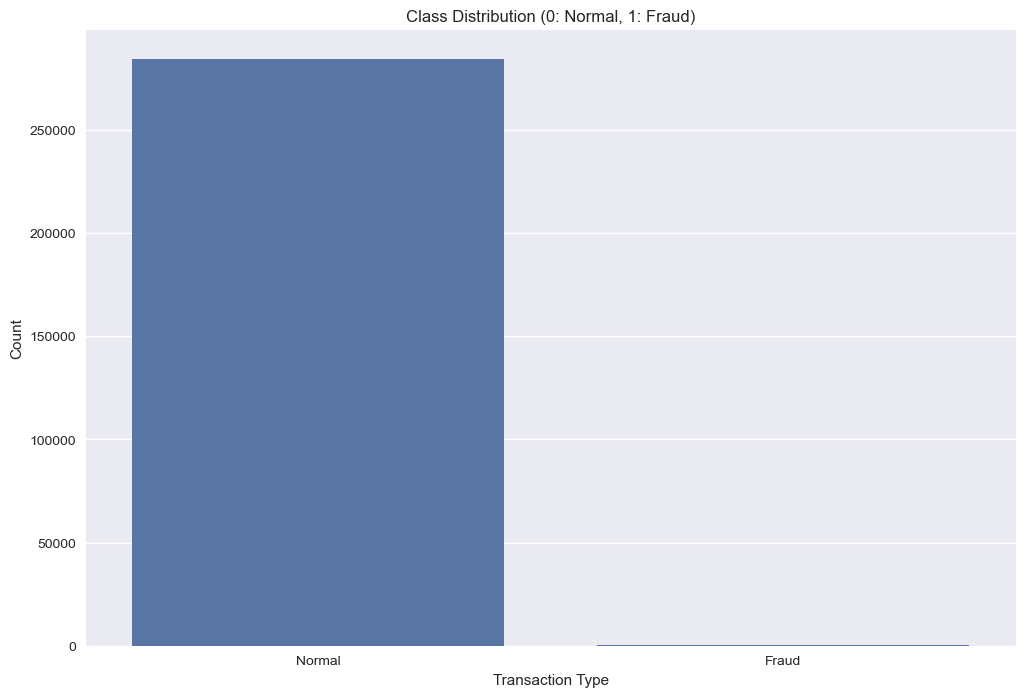

In [49]:
# Plot class distribution
plt_class = ccf.plot_class_distribution(df, config)
plt_class.show()

<Figure size 1200x800 with 0 Axes>

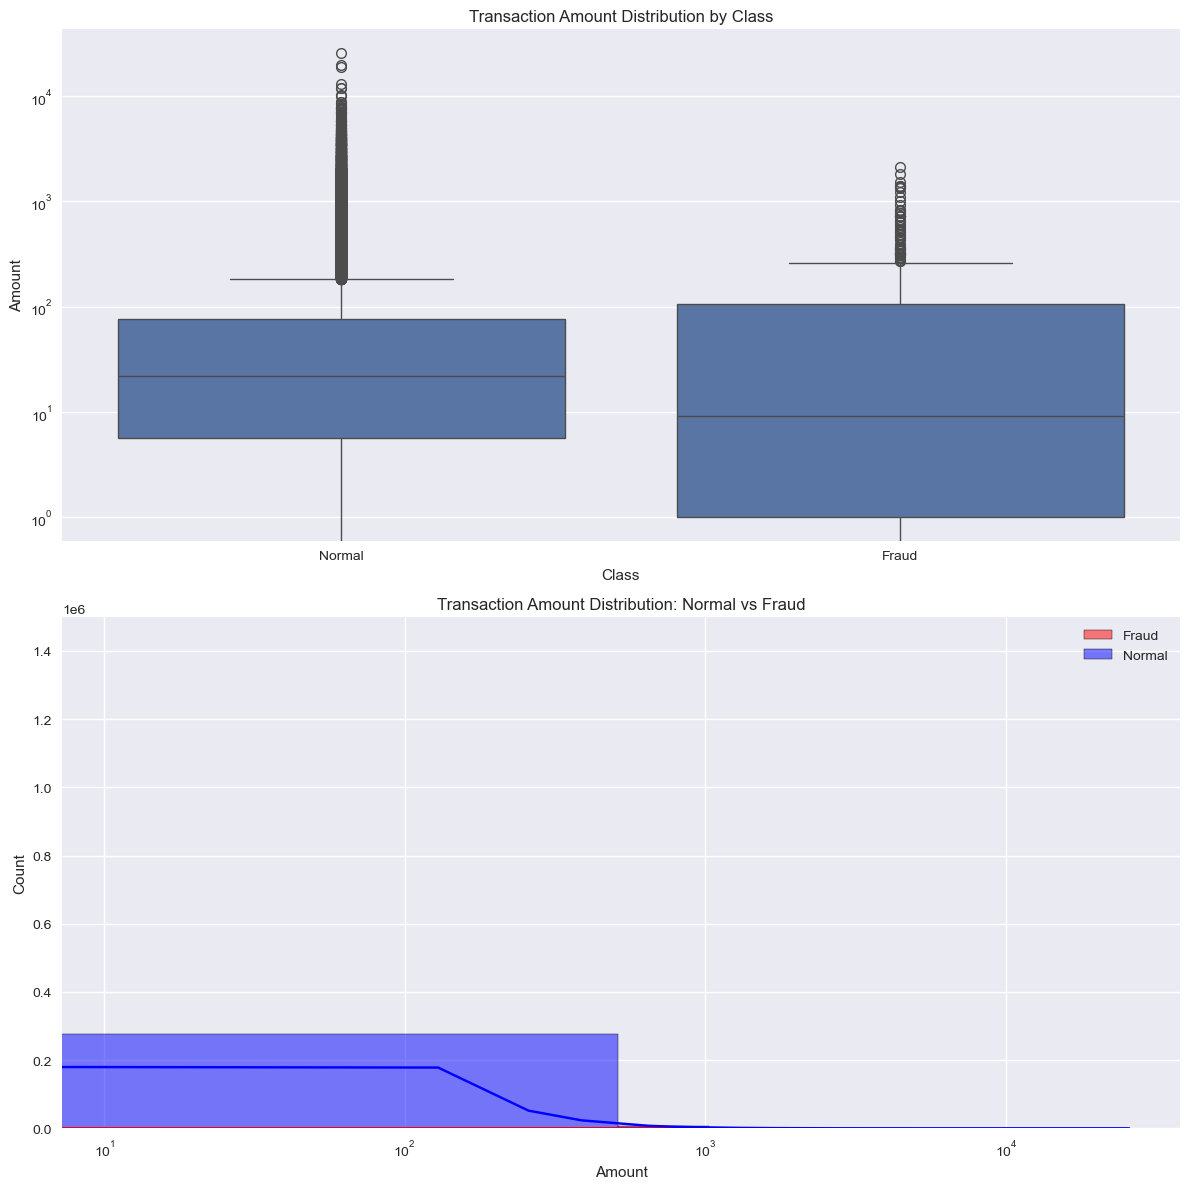

In [50]:
# Plot transaction amount distribution
plt_amount = ccf.plot_amount_distribution(df, config)
plt_amount.show()

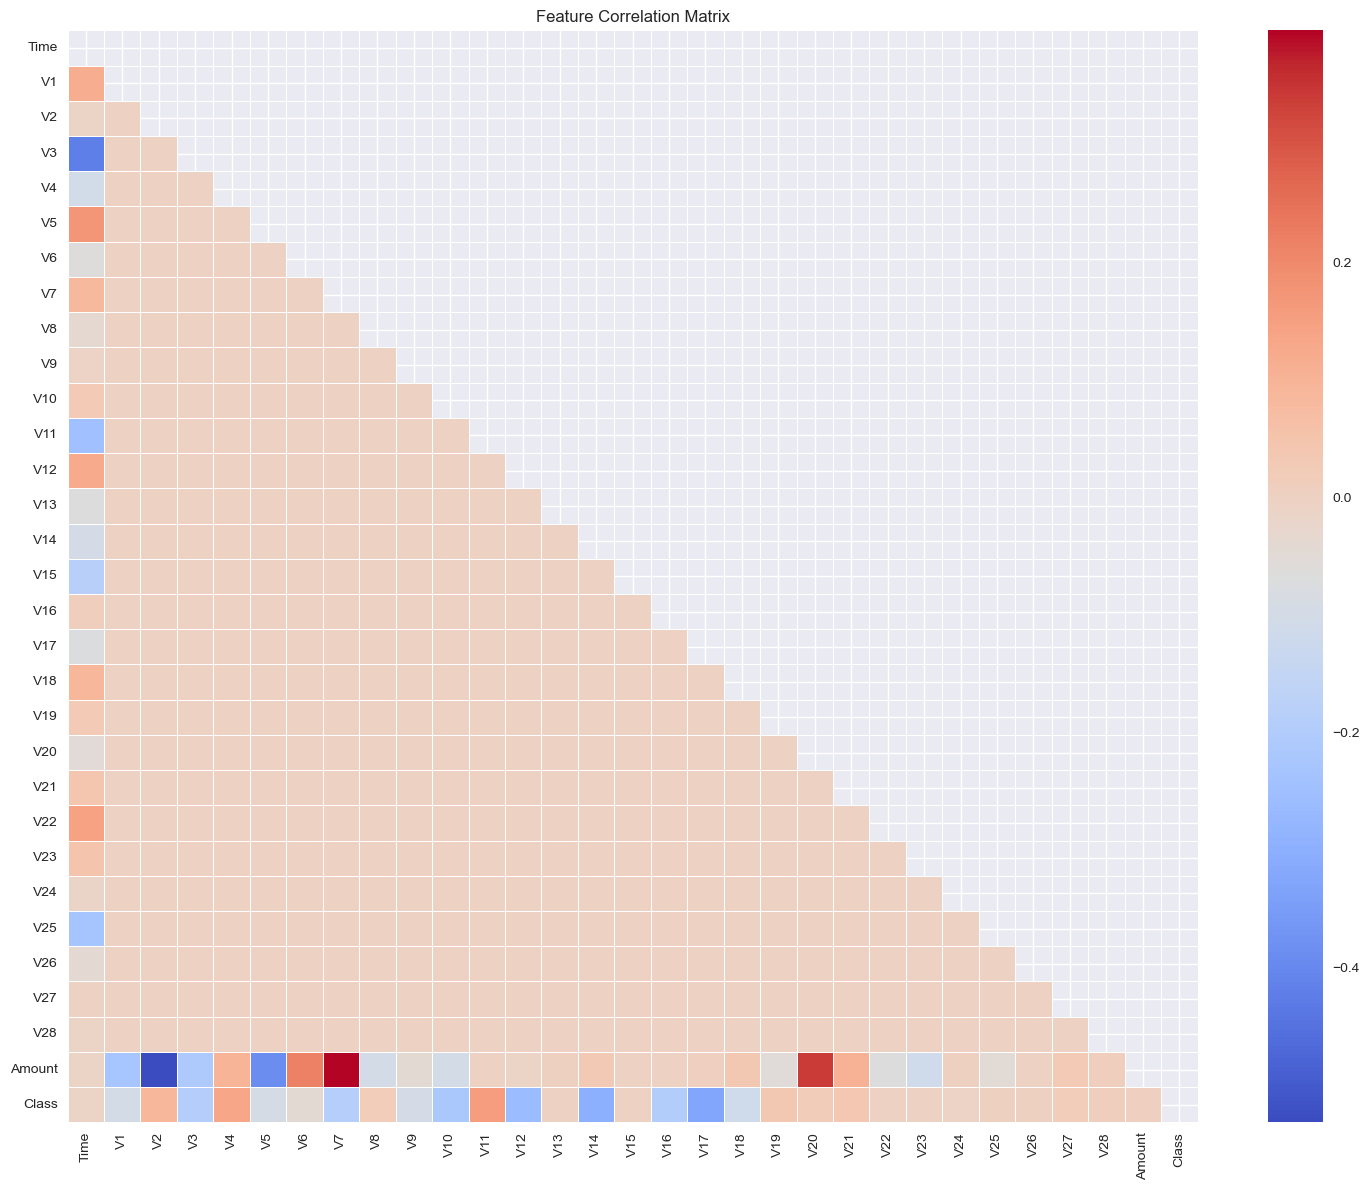

In [51]:
# Plot correlation matrix
plt_corr, corr_matrix = ccf.plot_correlation_matrix(df, config)
plt_corr.show()

Top 10 Features Correlated with Fraud:
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
Name: Class, dtype: float64


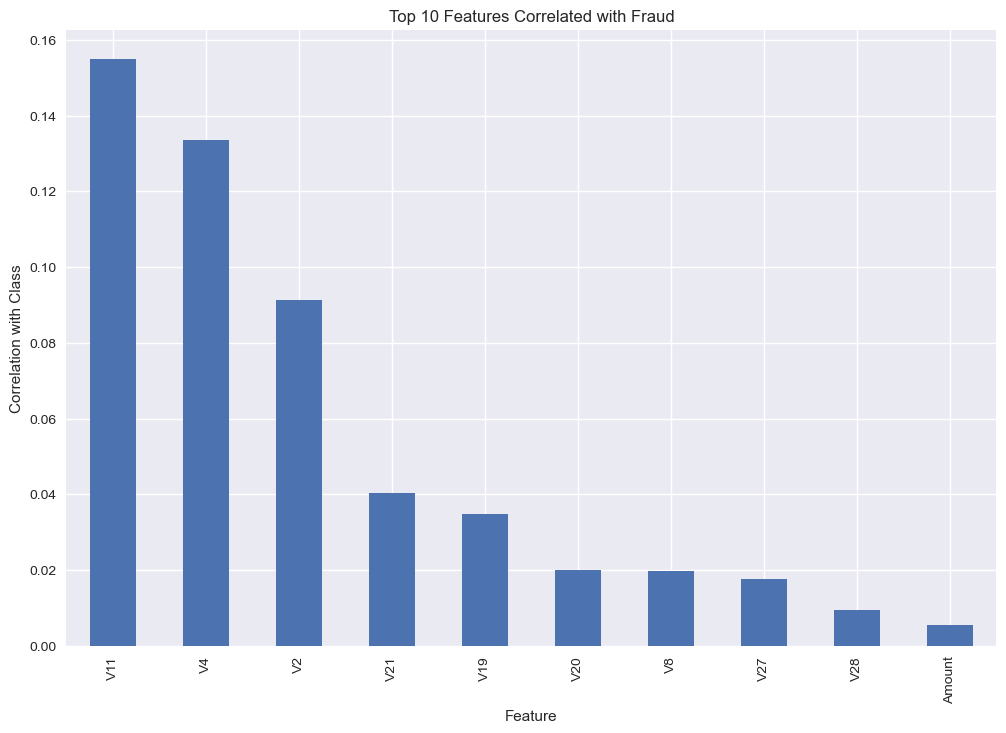

In [52]:
# Get top features correlated with fraud
top_correlations = ccf.get_top_correlations(corr_matrix, feature='Class', top_n=10)
print("Top 10 Features Correlated with Fraud:")
print(top_correlations)

# Visualize top correlations
plt.figure(figsize=config.FIGSIZE)
top_correlations.plot(kind='bar')
plt.title('Top 10 Features Correlated with Fraud')
plt.xlabel('Feature')
plt.ylabel('Correlation with Class')
plt.show()

## 4. Data Preprocessing

In [53]:
# Preprocess the data
X_train, X_test, y_train, y_test = ccf.preprocess_data(df, config)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set fraud percentage: {y_train.mean() * 100:.2f}%")
print(f"Testing set fraud percentage: {y_test.mean() * 100:.2f}%")

Training set shape: (227845, 30)
Testing set shape: (56962, 30)
Training set fraud percentage: 0.17%
Testing set fraud percentage: 0.17%


## 5. Handeling Imbalance

### Basline Model Logistic regression

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9990
Precision: 0.7128
Recall: 0.6837
F1-score: 0.6979
AUPRC: 0.6985


### Oversampling

In [55]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


X = df.drop(columns=['Class'])
y = df['Class']
oversample = RandomOverSampler(sampling_strategy='minority', random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)



model = LogisticRegression()
model.fit(X_over, y_over)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9643
Precision: 0.0430
Recall: 0.9286
F1-score: 0.0822
AUPRC: 0.4858


In [56]:
oversample = RandomOverSampler(sampling_strategy=0.002, random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)



model = LogisticRegression()
model.fit(X_over, y_over)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9987
Precision: 0.6429
Recall: 0.5510
F1-score: 0.5934
AUPRC: 0.5973


### Undersampling

In [57]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 42)
X_under, y_under = undersample.fit_resample(X_train, y_train)



model = LogisticRegression()
model.fit(X_under, y_under)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")


Accuracy: 0.9502
Precision: 0.0308
Recall: 0.9184
F1-score: 0.0596
AUPRC: 0.4747


### Smote

In [58]:

oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)



model = LogisticRegression()
model.fit(Xsmote, ysmote)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9676
Precision: 0.0453
Recall: 0.8878
F1-score: 0.0863
AUPRC: 0.4666


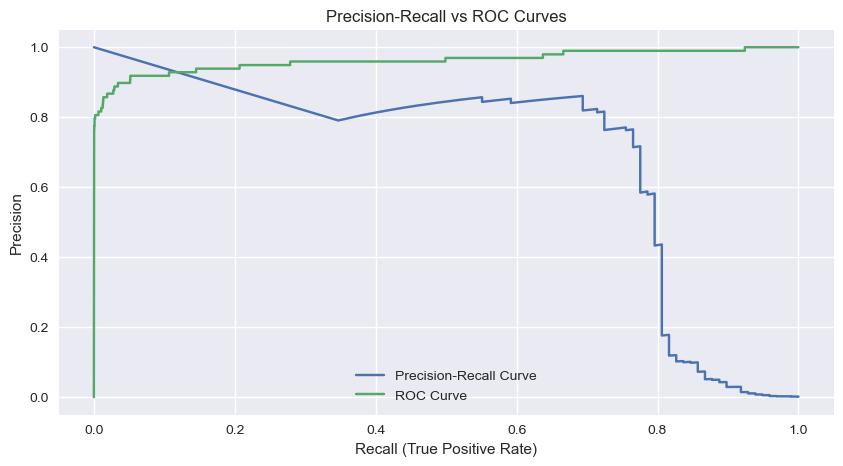

In [59]:
# Get predicted probabilities for the positive class (fraud)
y_scores = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)

# Get binary predictions for metrics
y_pred = model.predict(X_test)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

## Baseline benchmark for resampling

- Accuracy: 0.9576
- Precision: 0.9670
- Recall: 0.9478
- F1-score: 0.9573
- AUPRC: 0.9705

* **Recall at k% False Positive Rate (Recall @ k% FPR):** Businesses often have a tolerance limit for flagging legitimate transactions (FPR). For example, "We can tolerate investigating false alarms for 0.5% of our good transactions." You would then evaluate models based on how much fraud they catch (Recall) *at that specific, acceptable FPR level*. This directly links model performance to operational constraints.

* **Precision at k Recall:** Conversely, if the priority is to catch a certain percentage of all fraud (e.g., 90% Recall), you'd evaluate models based on how precise they are (how many flagged transactions are *actually* fraud) at that required Recall level.

* **Matthews Correlation Coefficient (MCC):** This is a robust metric for imbalanced binary classification that considers all four confusion matrix values (TP, TN, FP, FN). It ranges from -1 (total disagreement) to +1 (perfect prediction), with 0 being random guessing. It's often considered more informative than F1 when classes are very imbalanced. MCC = (TP×TN - FP×FN)/√[(TP+FP)(TP+FN)(TN+FP)(TN+FN)]

* **Kolmogorov-Smirnov (KS) Statistic:** Measures the maximum separation between the score distributions of the positive (fraud) and negative (normal) classes. A higher KS statistic indicates a better ability of the model to distinguish between fraud and non-fraud transactions based on its output score.

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve

def recall_at_k_fpr(y_true, y_scores, k=0.005):
    """
    Calculate recall at a specific false positive rate (FPR).
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_scores : array-like
        Predicted scores/probabilities
    k : float
        Target false positive rate (default: 0.005 or 0.5%)
        
    Returns:
    --------
    float
        Recall at the specified FPR
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # Find the threshold where FPR is closest to k
    idx = np.argmin(np.abs(fpr - k))
    return tpr[idx]

def precision_at_k_recall(y_true, y_scores, k=0.005):
    """
    Calculate precision at a specific recall rate.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_scores : array-like
        Predicted scores/probabilities
    k : float
        Target recall rate (default: 0.005 or 0.5%)
        
    Returns:
    --------
    float
        Precision at the specified recall
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    # Find the threshold where recall is closest to k
    idx = np.argmin(np.abs(recall - k))
    return precision[idx]

def ks_statistic(y_true, y_scores):
    """
    Calculate Kolmogorov-Smirnov statistic.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_scores : array-like
        Predicted scores/probabilities
        
    Returns:
    --------
    float
        KS statistic
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return np.max(np.abs(fpr - tpr))

# Now you can calculate all metrics
cm = confusion_matrix(y_test, y_pred)
recall_at_k_fpr = recall_at_k_fpr(y_test, y_scores, k=0.005)
p_at_k_recall = precision_at_k_recall(y_test, y_scores, k=0.005)
mcc = matthews_corrcoef(y_test, y_pred)
ks = ks_statistic(y_test, y_scores)

print(f"Confusion Matrix:\n{cm}")
print(f"Recall at 0.5% FPR: {recall_at_k_fpr:.4f}")
print(f"Precision at 0.5% Recall: {p_at_k_recall:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Kolmogorov-Smirnov Statistic: {ks:.4f}")


Confusion Matrix:
[[55032  1832]
 [   11    87]]
Recall at 0.5% FPR: 0.8061
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.1965
Kolmogorov-Smirnov Statistic: 0.8667


## Compare logistic_reg+SMOTE, XGBoost, Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import all_metrics as all_metrics

oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)


model_logistic = LogisticRegression()
model_logistic.fit(Xsmote, ysmote)
y_pred_logistic = model_logistic.predict(X_test)


logistic_results = all_metrics.calculate_model_metrics(model_logistic, X_test, y_test, 'Logistic Regression')




Metrics for Logistic Regression:
Accuracy: 0.9805
Precision: 0.0742
Recall: 0.8980
F1-score: 0.1371
AUPRC: 0.7482
AUROC: 0.9689
Recall at 0.5% FPR: 0.8673
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.2550
Kolmogorov-Smirnov Statistic: 0.8805
Confusion Matrix:
[[55766  1098]
 [   10    88]]


In [70]:
model_xgb = XGBClassifier()
model_xgb.fit(Xsmote, ysmote)
y_pred_xgb = model_xgb.predict(X_test)

xgb_results = all_metrics.calculate_model_metrics(model_xgb, X_test, y_test, 'XGBoost')


Metrics for XGBoost:
Accuracy: 0.9994
Precision: 0.7798
Recall: 0.8673
F1-score: 0.8213
AUPRC: 0.8824
AUROC: 0.9870
Recall at 0.5% FPR: 0.9082
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.8221
Kolmogorov-Smirnov Statistic: 0.9220
Confusion Matrix:
[[56840    24]
 [   13    85]]


In [71]:
model_rf = RandomForestClassifier()
model_rf.fit(Xsmote, ysmote)
y_pred_rf = model_rf.predict(X_test)

rf_results = all_metrics.calculate_model_metrics(model_rf, X_test, y_test, 'Random Forest')



Metrics for Random Forest:
Accuracy: 0.9995
Precision: 0.8817
Recall: 0.8367
F1-score: 0.8586
AUPRC: 0.8792
AUROC: 0.9745
Recall at 0.5% FPR: 0.9082
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.8587
Kolmogorov-Smirnov Statistic: 0.9073
Confusion Matrix:
[[56853    11]
 [   16    82]]


## Find optimal model + optimal resampling

In [84]:
def evaluate_model_with_resampling_and_cv(model, X, y, resampling_method, model_name, cv=5, param_grid=None):
    """
    Evaluate a model with different resampling methods using stratified k-fold cross-validation.
    
    Parameters:
    -----------
    model : sklearn model
        Base model to evaluate
    X, y : array-like
        Data and target
    resampling_method : str
        Resampling method to use
    model_name : str
        Name of the model (for printing)
    cv : int, default=5
        Number of cross-validation folds
    param_grid : dict, default=None
        Dictionary with parameters names as keys and lists of parameter values to try
        
    Returns:
    --------
    dict
        Dictionary containing all calculated metrics and best parameters
    """
    from sklearn.model_selection import StratifiedKFold, GridSearchCV
    from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
    from imblearn.over_sampling import SMOTE, ADASYN
    from imblearn.combine import SMOTETomek, SMOTEENN
    from imblearn.under_sampling import RandomUnderSampler, NearMiss, RandomOverSampler
    from imblearn.pipeline import Pipeline
    import pandas as pd
    import numpy as np
    
    # Define scoring metrics with zero_division parameter
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score)
    }
    
    # Create resampling step
    if resampling_method == 'SMOTE':
        sampler = SMOTE(random_state=42)
    elif resampling_method == 'ADASYN':
        sampler = ADASYN(random_state=42)
    elif resampling_method == 'SMOTE-Tomek':
        sampler = SMOTETomek(random_state=42)
    elif resampling_method == 'RUS':
        sampler = RandomUnderSampler(random_state=42)
    elif resampling_method == 'NearMiss':
        sampler = NearMiss(version=1)
    elif resampling_method == 'SMOTE-ENN':
        sampler = SMOTEENN(random_state=42)
    elif resampling_method == 'None':
        sampler = None
    else:
        raise ValueError(f"Unknown resampling method: {resampling_method}")
    
    # Create pipeline with resampling step and model
    if sampler is not None:
        pipeline = Pipeline([
            ('sampler', sampler),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('model', model)
        ])
    
    # Define cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # If param_grid is provided, do grid search
    if param_grid is not None:
        # Prefix model parameters with 'model__'
        prefixed_param_grid = {'model__' + key: value for key, value in param_grid.items()}
        
        # For Logistic Regression, add max_iter parameter
        if isinstance(model, LogisticRegression):
            if 'max_iter' not in prefixed_param_grid:
                prefixed_param_grid['model__max_iter'] = [1000]
        
        # Create grid search
        grid_search = GridSearchCV(
            pipeline,
            param_grid=prefixed_param_grid,
            scoring=scoring,
            cv=cv_strategy,
            refit='f1',  # Optimize for F1 score
            return_train_score=True,
            verbose=1,
            n_jobs=-1
        )
        
        # Fit grid search
        print(f"\nPerforming grid search for {model_name} with {resampling_method}...")
        grid_search.fit(X, y)
        
        # Get best parameters and results
        best_params = grid_search.best_params_
        cv_results = grid_search.cv_results_
        
        # Format the results
        metrics = {
            'model': f"{model_name} with {resampling_method}",
            'best_params': {key.replace('model__', ''): value for key, value in best_params.items()},
            'best_f1': grid_search.best_score_,
            'test_accuracy': np.mean(cv_results['mean_test_accuracy']),
            'test_precision': np.mean(cv_results['mean_test_precision']),
            'test_recall': np.mean(cv_results['mean_test_recall']),
            'test_f1': np.mean(cv_results['mean_test_f1']),
            'test_roc_auc': np.mean(cv_results['mean_test_roc_auc']),
            'cv_results': cv_results
        }
    else:
        # No hyperparameter tuning, just cross-validation
        from sklearn.model_selection import cross_validate
        
        cv_results = cross_validate(
            pipeline,
            X, y,
            cv=cv_strategy,
            scoring=scoring,
            return_train_score=True
        )
        
        metrics = {
            'model': f"{model_name} with {resampling_method}",
            'test_accuracy': np.mean(cv_results['test_accuracy']),
            'test_precision': np.mean(cv_results['test_precision']),
            'test_recall': np.mean(cv_results['test_recall']),
            'test_f1': np.mean(cv_results['test_f1']),
            'test_roc_auc': np.mean(cv_results['test_roc_auc']),
            'cv_results': cv_results
        }
    
    return metrics

# Example usage with modified Logistic Regression parameters:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define models with their hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=100),
        'param_grid': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'solver': ['liblinear', 'saga'],
            'penalty': ['l1', 'l2'],
        }
    },

}

# Define resampling methods
resampling_methods = ['SMOTE', 'ADASYN', 'SMOTE-Tomek', 'RUS', 'NearMiss', 'SMOTE-ENN']

# Store results
results = {}

# Evaluate each model with each resampling method
for model_name, model_info in models.items():
    model_results = {}
    for method in resampling_methods:
        print(f"\nEvaluating {model_name} with {method}...")
        metrics = evaluate_model_with_resampling_and_cv(
            model_info['model'], X, y, 
            method, model_name,
            cv=5, param_grid=model_info['param_grid']
        )
        model_results[method] = metrics
    results[model_name] = model_results

# Create results dataframe
results_df = []
for model_name, model_results in results.items():
    for method, metrics in model_results.items():
        row = {
            'Model': model_name,
            'Resampling': method,
            'Accuracy': metrics['test_accuracy'],
            'Precision': metrics['test_precision'],
            'Recall': metrics['test_recall'],
            'F1 Score': metrics['test_f1'],
            'ROC AUC': metrics['test_roc_auc']
        }
        if 'best_params' in metrics:
            row['Best Parameters'] = str(metrics['best_params'])
        results_df.append(row)

results_table = pd.DataFrame(results_df)
print("\nResults Summary:")
print(results_table)

# Optionally, visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

# Plot F1 scores for each model/resampling combination
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='F1 Score', hue='Resampling', data=results_table)
plt.title('F1 Score Comparison by Model and Resampling Method')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_resampling_comparison.png')
plt.show()


Evaluating Logistic Regression with SMOTE...

Performing grid search for Logistic Regression with SMOTE...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

In [77]:
def display_model_results(results):
    """
    Display model results focusing on key fraud detection metrics.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model results
    """
    import pandas as pd
    import numpy as np
    
    # Create a list to store all metrics
    all_metrics = []
    
    for model_name, model_results in results.items():
        for method, metrics in model_results.items():
            # Extract key metrics
            metric_dict = {
                'Model': model_name,
                'Resampling': method,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1': metrics['f1'],
                'AUPRC': metrics['auprc'],
                'AUROC': metrics['auroc'],
                'Recall@0.5%FPR': metrics['recall_at_k'],
                'Precision@0.5%Recall': metrics['precision_at_k'],
                'MCC': metrics['mcc'],
                'KS': metrics['ks']
            }
            all_metrics.append(metric_dict)
    
    # Create DataFrame
    results_df = pd.DataFrame(all_metrics)
    
    # Format the display
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', '{:.4f}'.format)
    
    # Sort by AUPRC (most important metric for fraud detection)
    results_df = results_df.sort_values(['Model', 'AUPRC'], ascending=[True, False])
    
    # Display results
    print("\nModel Comparison Results:")
    display(results_df[['Model', 'Resampling', 'Accuracy', 'Precision', 'Recall', 
                       'F1', 'AUPRC', 'AUROC', 'Recall@0.5%FPR', 
                       'Precision@0.5%Recall', 'MCC', 'KS']])
    
    # Create visualizations
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style
    plt.style.use('seaborn')
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: AUPRC comparison
    sns.barplot(data=results_df, x='Model', y='AUPRC', hue='Resampling', ax=axes[0, 0])
    axes[0, 0].set_title('AUPRC by Model and Resampling Method')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Recall@0.5%FPR comparison
    sns.barplot(data=results_df, x='Model', y='Recall@0.5%FPR', hue='Resampling', ax=axes[0, 1])
    axes[0, 1].set_title('Recall@0.5%FPR by Model and Resampling Method')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Precision comparison
    sns.barplot(data=results_df, x='Model', y='Precision', hue='Resampling', ax=axes[1, 0])
    axes[1, 0].set_title('Precision by Model and Resampling Method')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot 4: F1-score comparison
    sns.barplot(data=results_df, x='Model', y='F1', hue='Resampling', ax=axes[1, 1])
    axes[1, 1].set_title('F1-score by Model and Resampling Method')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print best performing model for each metric
    print("\nBest Performing Models:")
    metrics_to_compare = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUPRC', 
                         'AUROC', 'Recall@0.5%FPR', 'Precision@0.5%Recall', 'MCC', 'KS']
    
    for metric in metrics_to_compare:
        best_idx = results_df[metric].idxmax()
        best_model = results_df.loc[best_idx, 'Model']
        best_method = results_df.loc[best_idx, 'Resampling']
        best_value = results_df.loc[best_idx, metric]
        print(f"{metric}: {best_model} with {best_method} ({best_value:.4f})")

# Example usage:
display_model_results(results)



Model Comparison Results:


,Model,Resampling,Accuracy,Precision,Recall,F1,AUPRC,AUROC,Recall@0.5%FPR,Precision@0.5%Recall,MCC,KS
1,Logistic Regression,ADASYN,0.9140,0.0181,0.9184,0.0355,0.7957,0.9725,0.8878,1.0000,0.1221,0.9011
5,Logistic Regression,SMOTE-ENN,0.9727,0.0550,0.9184,0.1038,0.7888,0.9702,0.8878,1.0000,0.2211,0.9001
0,Logistic Regression,SMOTE,0.9742,0.0580,0.9184,0.1092,0.7704,0.9699,0.8878,1.0000,0.2273,0.9001
2,Logistic Regression,SMOTE-Tomek,0.9742,0.0580,0.9184,0.1092,0.7704,0.9699,0.8878,1.0000,0.2273,0.9001
3,Logistic Regression,RUS,0.9604,0.0385,0.9184,0.0739,0.7177,0.9759,0.8878,1.0000,0.1835,0.9050
4,Logistic Regression,NearMiss,0.6115,0.0042,0.9592,0.0084,0.0745,0.9241,0.2347,1.0000,0.0484,0.7062


OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)